In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import cv2
import numpy as np
from scipy.io import loadmat
from scipy import ndimage, spatial
from skimage import io, img_as_float
import matplotlib.pyplot as plt
%matplotlib inline

# Part 1: Shape Alignment (30 Points)

## Overview
In this problem, you will write a function that aligns two sets of points using
iterative closest point (ICP) to output an affine image transformation $T$  where $T$ is a transformation that maps non-zero points in $im1$ to non-zero points in $im2$.

<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/shape_align.jpeg" width="1000"/>

We have provided 25 image pairs provided to you to test your code, but you don't have to try all of them. Please include the output of your code on the 10 image pairs from the examples provided in the supplementary material. We have included functions
**evalAlignmentAll and displayAlignment to help with evaluation and display**.




## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 18Px9uQyY1fGGyEAQhzt3h4yDQonU_Sgm
!unzip "/content/part2_images.zip" -d "/content/"

## Helper Functions

In [ ]:
def evalAlignment(aligned1, im2):
  '''
  Computes the error of the aligned image (aligned1) and im2, as the
  average of the average minimum distance of a point in aligned1 to a point in im2
  and the average minimum distance of a point in im2 to aligned1.
  '''
  d2 = ndimage.distance_transform_edt(1-im2) #distance transform
  err1 = np.mean(np.mean(d2[aligned1 > 0]))
  d1 = ndimage.distance_transform_edt(1-aligned1);
  err2 = np.mean(np.mean(d2[im2 > 0]))
  err = (err1+err2)/2;
  return err

def displayAlignment(im1, im2, aligned1, thick=False):
  '''
  Displays the alignment of im1 to im2
     im1: first input image to alignment algorithm (im1(y, x)=1 if (y, x)
      is an original point in the first image)
     im2: second input image to alignment algorithm
     aligned1: new1(y, x) = 1 iff (y, x) is a rounded transformed point from the first time
     thick: true if a line should be thickened for display
  '''
  if thick:
    # for thick lines (looks better for final display)
    dispim = np.concatenate((cv2.dilate(im1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(aligned1.astype('uint8'), np.ones((3,3), np.uint8), iterations=1), \
                             cv2.dilate(im2.astype('uint8'), np.ones((3,3), np.uint8), iterations=1)), axis=-1)
  else:
    # for thin lines (faster)
    dispim = np.concatenate((im1, aligned1, im2), axis = -1)
  return dispim


## Code (15 pts)


The align_shape function takes in two numpy arrays s and st as inputs and returns an aligned version of s that matches the shape of st. The function first initializes the transformation matrix T with a simple translation that aligns the origins of the two images. The iterative closest point algorithm is then applied to iteratively refine the alignment of s with st.

In each iteration of the algorithm, the function transforms s using the current transformation matrix T and finds the closest corresponding points between s and st using nearest neighbors search. The function then solves a linear system to obtain a new transformation matrix that maps s to st. The new transformation matrix is composed with the old transformation matrix to obtain the updated transformation matrix T_new. The loop terminates when either the maximum number of iterations is reached or the change in transformation matrix is below a certain threshold.



In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from skimage.transform import AffineTransform, warp

def align_shape(im1, im2):

    # Pad the images
    pad_size = 100
    im1 = np.pad(im1, pad_size, mode='constant')
    im2 = np.pad(im2, pad_size, mode='constant')

    # Initialize transformation matrix with a simple translation and scaling to align COM

    std_1 = np.std(im1)
    std_2 = np.std(im2)
    scale_factor = std_2 / std_1

    mean_1 = np.mean(np.nonzero(im1), axis=1)
    mean_2 = np.mean(np.nonzero(im2), axis=1)


    T = np.array([[scale_factor, 0, mean_2[1] - mean_1[1]],
                  [0, scale_factor, mean_2[0] - mean_1[0]],
                  [0, 0, 1]])

    # Iterative closest point algorithm
    max_iterations = 200
    stop_eps = 0.01
    prev_error = 0
    for i in range(max_iterations):
        # Transform s using current transformation matrix T
        im1_transformed = warp(im1, AffineTransform(matrix=T))

        # Find closest corresponding points between s_transformed and st
        nn = NearestNeighbors(n_neighbors=1)
        nn.fit(np.transpose(np.nonzero(im2)))
        distances, indices = nn.kneighbors(np.transpose(np.nonzero(im1_transformed)))
        correspondences_1 = np.transpose(np.nonzero(im1_transformed))
        correspondences_2 = np.transpose(np.nonzero(im2))[indices.ravel()]

        # Solve for transformation matrix
        A = np.zeros((2 * correspondences_1.shape[0], 6))
        b = np.zeros((2 * correspondences_1.shape[0], 1))
        for j in range(correspondences_1.shape[0]):
            A[2*j:2*j+2, :] = [[correspondences_1[j, 1], correspondences_1[j, 0], 1, 0, 0, 0],
                               [0, 0, 0, correspondences_1[j, 1], correspondences_1[j, 0], 1]]
            b[2*j:2*j+2] = [[correspondences_2[j, 1]], [correspondences_2[j, 0]]]
        try:
            x = np.linalg.lstsq(A, b, rcond=None)[0]
            T_new = np.eye(3)
            T_new[:2, :] = np.reshape(x, (2, 3))
            T = T @ np.linalg.inv(T_new)
        except:
            break


        # Check for convergence
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < stop_eps:
            break
        prev_error = mean_error


    # Apply final transformation to s and return aligned image
    aligned = warp(im1, AffineTransform(matrix=T))
    aligned = aligned[pad_size:-pad_size, pad_size:-pad_size]


    return aligned


apple Error: 1.7393165632272862 Runtime: 0.36337757110595703 seconds


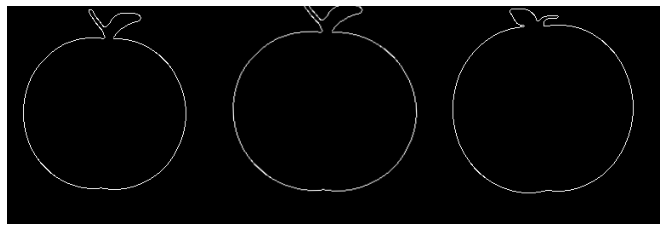

bell Error: 0.9456707404245308 Runtime: 0.9094080924987793 seconds


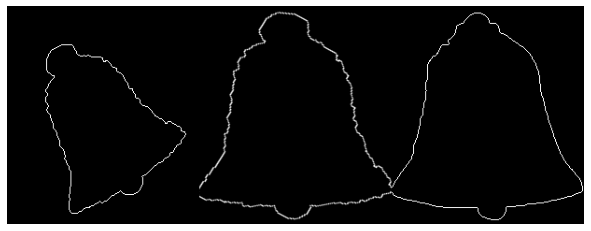

bottle Error: 2.291241440261685 Runtime: 0.3287773132324219 seconds


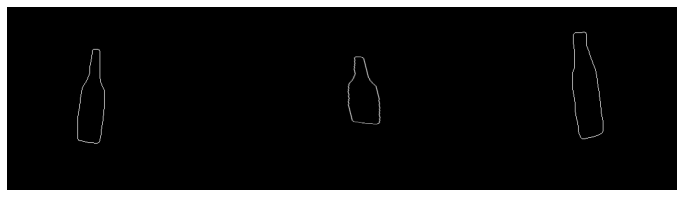

bat Error: 4.463785111512276 Runtime: 1.393188238143921 seconds


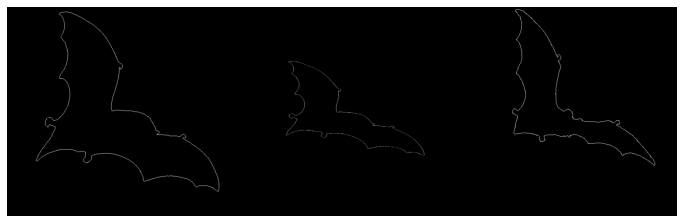

car Error: 1.1174840857928958 Runtime: 0.6748137474060059 seconds


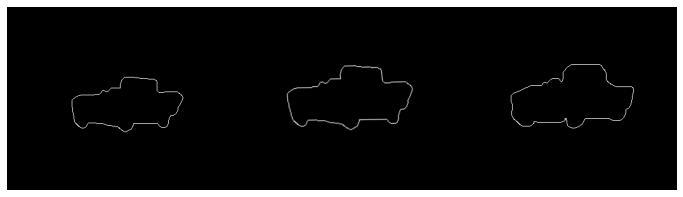

chicken Error: 2.7839458067066816 Runtime: 0.3228933811187744 seconds


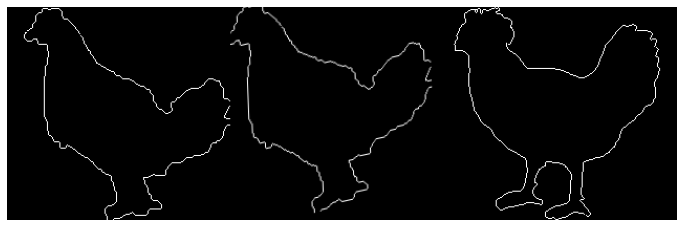

children Error: 0.44009547729609244 Runtime: 0.1992955207824707 seconds


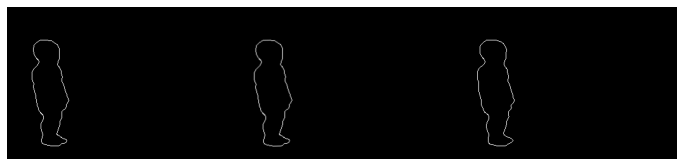

device7 Error: 0.7129433091464437 Runtime: 1.4352664947509766 seconds


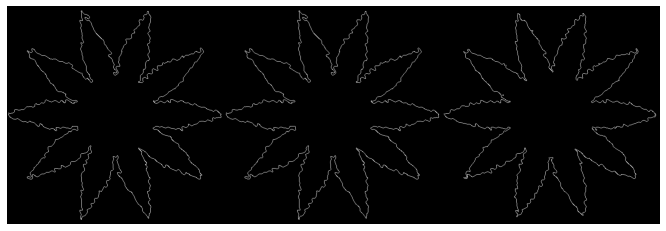

face Error: 0.5885262569730988 Runtime: 0.4089949131011963 seconds


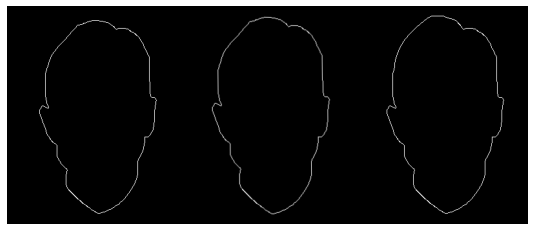

Heart Error: 2.019117722488947 Runtime: 0.6575984954833984 seconds


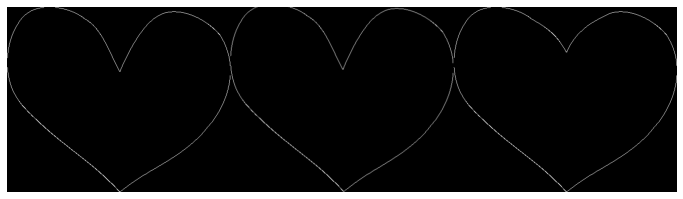

In [ ]:
# This is the final plot for 10 image pairs as requested!

import time
imgPath = '/content/part2_images/';

objList = ['apple', 'bell', 'bottle', 'bat', 'car',
           'chicken', 'children', 'device7', 'face', 'Heart']

numObj = len(objList)


# Add code to run align_shape() and display the results and the errors
for i in range(numObj):
    # Load the images
    im1 = plt.imread(imgPath + objList[i] + '_1.png')
    im2 = plt.imread(imgPath + objList[i] + '_2.png')

    # Record the start time
    start_time = time.time()

    # Run align_shape()
    aligned = align_shape(im1, im2)

    # Record the end time and calculate the runtime
    end_time = time.time()
    runtime = end_time - start_time

    # Display the results, error, and runtime
    err = evalAlignment(aligned, im2)
    print(objList[i], "Error:", err, "Runtime:", runtime, "seconds")
    dispim = displayAlignment(im1, im2, aligned)
    plt.figure(figsize=(12, 4))
    plt.imshow(dispim, cmap='gray')
    plt.axis('off')
    plt.show()



## Write-up (15 pt)

1. (5 pts) Give a brief explanation of your algorithm, initialization, and model of the transformation. -> **Answer below**

2. (10 pts) For each result, give: -> **All of these are shown above**
  1.   The alignment display
  2.   The final error
  3.   The runtime






**Question1 Answer, brief of algorithm used:**

Answer:

The align_shape function aligns two images using the Iterative Closest Point (ICP) algorithm. It initializes a transformation matrix based on the center of mass and standard deviation of the input images, then iteratively refines the matrix to minimize the distance between corresponding points in the two shapes. The algorithm converges when the mean error of distances between points falls below a specified threshold. The final aligned image is obtained by applying the refined affine transformation matrix to the input image and cropping the padded regions, that were padded first in the function to account for any change of scale or potential cropping.

# Part 2: Object Instance Recognition (20 points)

## Overview
This problem explores the Lowe-style object instance recognition.

Implement the nearest neighbor distance ratio test using the pre-computed SIFT features SIFT_features.mat provided in the supplementary material. The Frame1, Frame2 indicate the 2D position, scales, and the orientation of the descriptors and Descriptor1, Descriptor2 are the correspondin 128-D SIFT features. Display the matches like this:

<img src="https://www.cs.umd.edu/class/spring2023/cmsc426-0201/hw_images/Lowe_rec.jpeg" width="1000"/>



## Data

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 10ByzpFbB-z178VGjwmCwc95wInD8vpNM # SIFT Features
!gdown 1KLWGMtDEMNNrmzd3Qezrs2-NQR52OfoU # Stop sign image 1
!gdown 13y-o1vdGN6CqqPuUcgU7pIxODTxrYS7J # Stop sign image 1

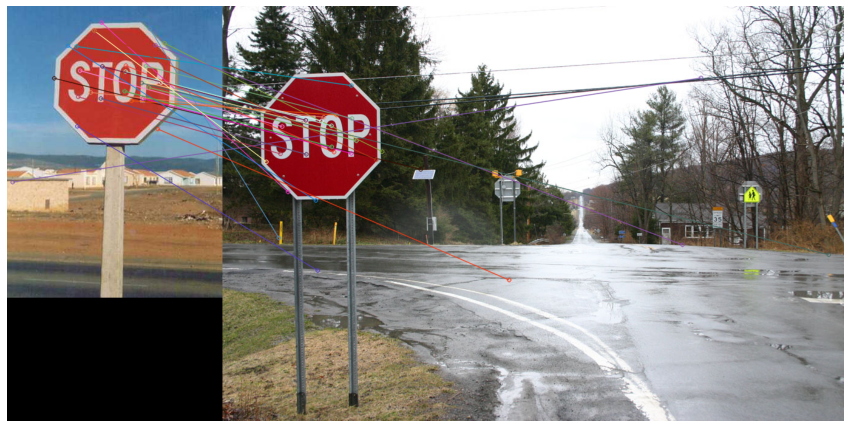

In [ ]:
# This is an implementation using cv2 sift and feature matching libraries to compare results
# Note that it shows very similar result to what we got using Lowe-style as below
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# read images
img1 = plt.imread('/content/stop1.jpg')
img2 = plt.imread('/content/stop2.jpg')


#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)


img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:30], img2, flags=2)

plt.figure(figsize=(15,10))
plt.imshow(img3)
plt.axis('off')
plt.show()


In [ ]:
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [ ]:
# Define fun to apply lowe-style for matching descriptors
# The function has a param that "method" which is used to switch between
# two methods; "ratio" -> for dist ratio test , "distance" -> for dist threshold test

def find_matches(descriptor1, descriptor2, method='ratio', threshold=0.7):
    matches = []
    descriptor1 = descriptor1.astype(float)
    descriptor2 = descriptor2.astype(float)

    for i, g in enumerate(descriptor1.T):
        distances = np.linalg.norm(descriptor2 - g.reshape(-1, 1), axis=0)
        sorted_idx = np.argsort(distances)
        closest_neighbour = distances[sorted_idx[0]]
        second_closest_neighbour = distances[sorted_idx[1]]

        if method == 'ratio':
            if closest_neighbour / second_closest_neighbour < threshold:
                matches.append([i, sorted_idx[0]])
        elif method == 'distance':
            if closest_neighbour <= threshold:
                matches.append([i, sorted_idx[0]])
        else:
            raise ValueError("Invalid method specified. Choose either 'ratio' or 'distance'.")

    return np.array(matches).T


In [ ]:
# Define plot_matches to plot matched keypoints in two images and lines connect them
def plot_matches(img1, img2, frame1, frame2, matches):
    # Convert images to RGB
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Initialize output image
    h1, w1 = img1_rgb.shape[:2]
    h2, w2 = img2_rgb.shape[:2]
    output = np.zeros((max(h1, h2), w1 + w2, 3), dtype="uint8")

    # Place images side by side
    output[0:h1, 0:w1] = img1_rgb
    output[0:h2, w1:] = img2_rgb

    # Extract X, Y coordinates from frames
    x1, y1 = frame1[0, matches[0]], frame1[1, matches[0]]
    x2, y2 = frame2[0, matches[1]], frame2[1, matches[1]]

    for i in range(matches.shape[1]):
        # Draw lines connecting matched keypoints
        pt1 = (int(x1[i]), int(y1[i]))
        pt2 = (int(x2[i]) + w1, int(y2[i]))
        cv2.line(output, pt1, pt2, (0, 255, 0), 1)

        # Draw keypoints on img1
        cv2.circle(output, pt1, 5, (255, 0, 0), -1)
        # Draw keypoints on img2
        cv2.circle(output, pt2, 5, (255, 0, 0), -1)


    plt.figure(figsize=(15,10))
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


## Code (10 pts)

Matches found by thresholding nearest neighbor distances: 30


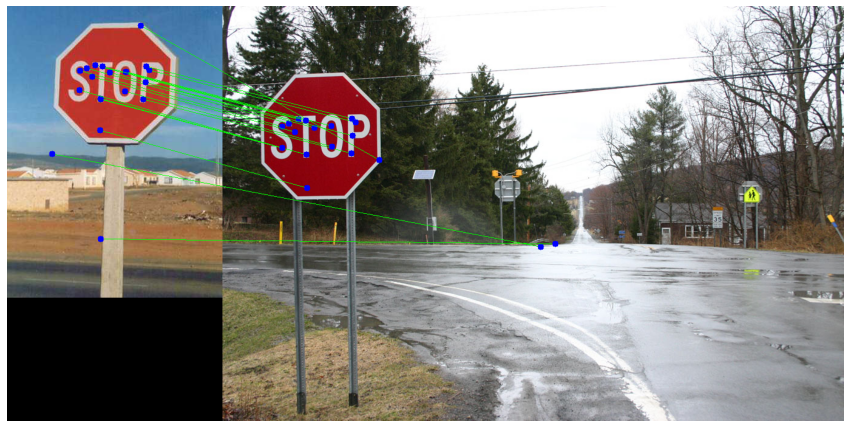

Matches found by thresholding the distance ratio: 30


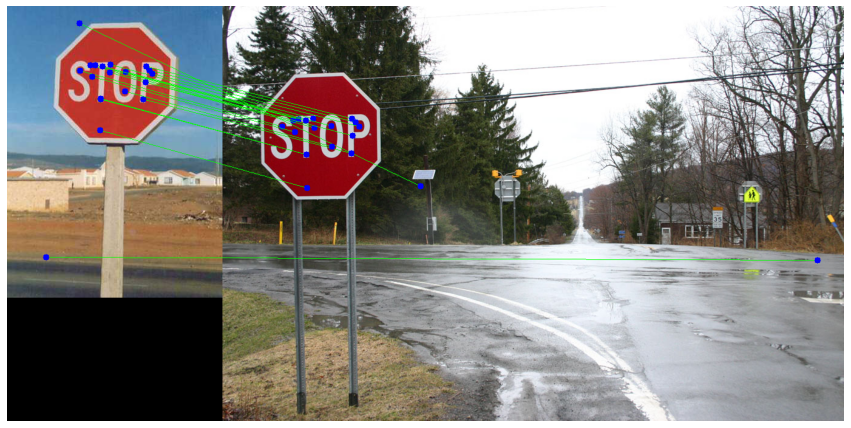

In [ ]:
img1 = plt.imread('/content/stop1.jpg')
img2 = plt.imread('/content/stop2.jpg')

## inside the sift are:
## Descriptor1, Descriptor2: SIFT features from image 1 and image 2
## Frame1, Frame2: position, scale, rotation of keypoints
data = loadmat('/content/SIFT_features.mat')
Frame1 = data['Frame1']
Descriptor1 = data['Descriptor1']
Frame2 = data['Frame2']
Descriptor2 = data['Descriptor2']


# Find matches by thresholding nearest neighbor distances
matches_distance = find_matches(Descriptor1, Descriptor2, method='distance', threshold=130.0)
print(f"Matches found by thresholding nearest neighbor distances: {matches_distance.shape[1]}")
plot_matches(img1, img2, Frame1, Frame2, matches_distance)

# Find matches by thresholding the distance ratio
matches_ratio = find_matches(Descriptor1, Descriptor2, method='ratio', threshold=0.6)
print(f"Matches found by thresholding the distance ratio: {matches_ratio.shape[1]}")
plot_matches(img1, img2, Frame1, Frame2, matches_ratio)


## Write-up (10 pts)

(5 pts) Display:

1. the matches by thresholding nearest neighbor distances. -> **plot above**

2. the matches by thresholding the distance ratio. -> **plot above**

(5 pts) Describe the differences of (1) and (2). -> **Answer Below**




**Answer:**

Thresholding the nearest neighbors distance means setting a maximum distance value (threshold) to decide if two feature points are considered a match or not. When comparing two feature descriptors, if the Euclidean distance between them is less than or equal to the threshold, they are considered a match. If the distance is greater than the threshold, they are not considered a match.

However, thresholding the distance ratio is like the implemented function where it calculates the distances between each descriptor in descriptor1 and all the descriptors in descriptor2, and then checks if the ratio of the closest neighbor distance to the second closest neighbor distance is below the threshold. If it is, the function records the match by appending the indices of the keypoints from the two images to a list.